In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df= pd.read_csv('data/raw_posts.csv')

In [3]:
df.isnull().sum()

subreddit        0
title            0
selftext       336
created_utc      0
dtype: int64

In [4]:
df.dropna(subset=['selftext'], inplace=True)

In [5]:
df['subreddit_id'] = df['subreddit']

#### What are the most common words in each subreddit?

In [6]:
cv= CountVectorizer(stop_words='english')
data = cv.fit_transform(df['selftext'])
df_cv= pd.DataFrame(data.A, columns=cv.get_feature_names_out())
df_cv.head(2)

,00,000,000184085681,000ft,000km,000lbs,008m,00am,00km,00min,...,zones,zoom,zoomies,zooming,zooms,zoomx,zoooooooom,zorro,zwift,zylkene
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_cv.sum().sort_values(ascending=False).head(25)

dog         4976
just        4221
run         3338
running     3292
time        3189
like        3067
ve          3053
training    2560
dogs        2054
really      1916
old         1867
don         1795
week        1687
day         1678
know        1667
race        1642
want        1552
got         1530
started     1400
year        1308
going       1302
marathon    1286
long        1235
good        1228
miles       1209
dtype: int64

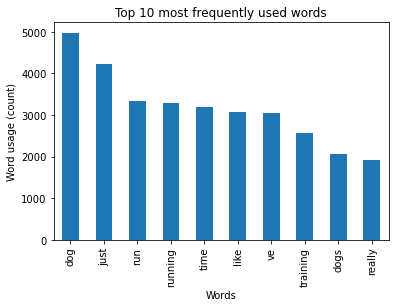

In [8]:
df_cv.sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 most frequently used words')
plt.xlabel('Words')
plt.ylabel('Word usage (count)');

#### Split Data into train and test

In [9]:
X=df['selftext']
y=df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=20, stratify=y)

#### Establish a baseline model and determine what are the most impactful words?

In [10]:
cv=CountVectorizer(stop_words='english')
cv.fit(X_train)

CountVectorizer(stop_words='english')

In [11]:
X_train_cv= cv.transform(X_train)
X_test_cv= cv.transform(X_test)

In [12]:
lr = LogisticRegression()
lr.fit(X_train_cv, y_train)

LogisticRegression()

In [13]:
lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(0.9729354614850798, 0.9569743233865371)

In [14]:
preds= lr.predict(X_train_cv)

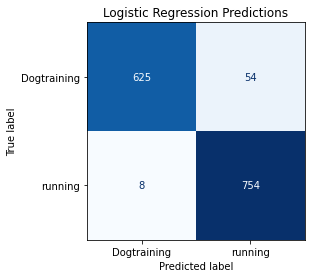

In [15]:
ConfusionMatrixDisplay.from_estimator(lr, X_test_cv, y_test, cmap='Blues', colorbar=False)
plt.title('Logistic Regression Predictions');

In [16]:
cv_df= pd.DataFrame(X_train_cv.A, columns= cv.get_feature_names_out())

In [17]:
cv_df.sum().sort_values(ascending=False).head(15)

dog         3746
just        3130
run         2533
running     2491
time        2388
like        2297
ve          2256
training    1929
really      1476
dogs        1476
old         1412
don         1341
race        1334
week        1319
know        1273
dtype: int64

In [18]:
coef_df=pd.DataFrame(lr.coef_[0], index= cv.get_feature_names_out(), columns=['coef_score'])

In [19]:
coef_df.sort_values(by='coef_score', ascending=False).head(40).index

Index(['running', 'run', 'marathon', 'race', 'runs', 'ran', 'shoes', 'runner',
       'runners', 'pain', 'miles', 'mile', 'track', 'post', 'treadmill', 'app',
       'title', 'wondering', 'foot', 'pace', 'jogging', 'shoe', 'https',
       'thread', 'curious', 'week', '5k', 'haven', 'body', 'atl', 'half',
       'hill', 'fast', 'feel', 'live', 'achievement', 'ankle', 'pair',
       'school', 'jog'],
      dtype='object')

In [20]:
coef_df.sort_values(by='coef_score', ascending=False).tail(40).index

Index(['outside', 'vet', 'bothering', 'close', 'sit', 'doesn', 'advise', 'pet',
       'pee', 'barking', 'away', 'barks', 'explain', 'toys', 'boy', 'say',
       'teach', 'gsd', 'behavior', 'potty', 'tips', 'loves', 'trainer',
       'leave', 'collar', 'food', 'house', 'treats', 'play', 'gets', 'train',
       'crate', 'treat', 'help', 'leash', 'dogs', 'pup', 'puppy', 'old',
       'dog'],
      dtype='object')

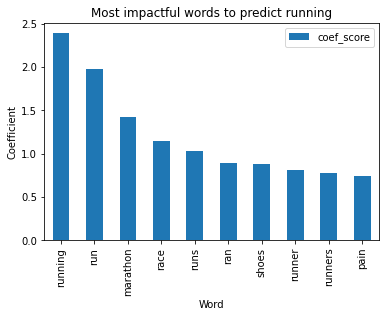

In [21]:
coef_df.sort_values(by='coef_score', ascending=False).head(10).plot(kind='bar')
plt.title('Most impactful words to predict running')
plt.xlabel('Word')
plt.ylabel('Coefficient');

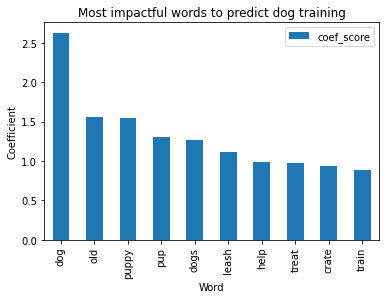

In [22]:
abs(coef_df.sort_values(by='coef_score', ascending=True).head(10)).plot(kind='bar')
plt.title('Most impactful words to predict dog training')
plt.xlabel('Word')
plt.ylabel('Coefficient');

Logistic Regression with the standard parameters does a very good job of identifying which subreddit a post came from. This indicates that the subreddits may be too divergent. To make the problem harder, I will create a custom list of stop words that exclude the most common words in each subreddit

#### Creating Custom Stop Words

In [28]:
custom_stop_words= ['running', 'run', 'marathon', 'race', 'runs', 'ran', 'shoes', 'runner',
       'runners', 'pain', 'miles', 'mile', 'track', 'post', 'treadmill', 'app',
       'title', 'wondering', 'foot', 'pace', 'jogging', 'shoe', 'https',
       'thread', 'curious', 'week', '5k', 'haven', 'body', 'atl', 'half',
       'hill', 'fast', 'feel', 'live', 'achievement', 'ankle', 'pair',
       'school', 'jog','outside', 'vet', 'bothering', 'close', 'sit', 'doesn', 'advise', 'pet',
       'pee', 'barking', 'away', 'barks', 'explain', 'toys', 'boy', 'say',
       'teach', 'gsd', 'behavior', 'potty', 'tips', 'loves', 'trainer',
       'leave', 'collar', 'food', 'house', 'treats', 'play', 'gets', 'train',
       'crate', 'treat', 'help', 'leash', 'dogs', 'pup', 'puppy', 'old',
       'dog']

In [29]:
len(custom_stop_words)

80

#### Create a new basline model with the custom stop words

In [30]:
cv2 = CountVectorizer(stop_words=custom_stop_words)

In [31]:
df_cv.sum().sort_values(ascending=False).head(10)

dog         4976
just        4221
run         3338
running     3292
time        3189
like        3067
ve          3053
training    2560
dogs        2054
really      1916
dtype: int64

In [37]:
pipe2 = make_pipeline(
    CountVectorizer(stop_words=custom_stop_words),
    LogisticRegression()
)

In [38]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['running', 'run', 'marathon',
                                             'race', 'runs', 'ran', 'shoes',
                                             'runner', 'runners', 'pain',
                                             'miles', 'mile', 'track', 'post',
                                             'treadmill', 'app', 'title',
                                             'wondering', 'foot', 'pace',
                                             'jogging', 'shoe', 'https',
                                             'thread', 'curious', 'week', '5k',
                                             'haven', 'body', 'atl', ...])),
                ('logisticregression', LogisticRegression())])

In [39]:
pipe2.score(X_train, y_train), pipe2.score(X_test,y_test)

(0.972704140643072, 0.9403192227619709)

#### Pickling & Exporting for later use

In [40]:
with open('./pickles/custom_words.pkl', 'wb') as pickle_out:
    pickle.dump(custom_stop_words, pickle_out)

In [41]:
df.to_csv('./data/cleaned_posts.csv', index=False)